In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as TT
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

import torch.optim as optim
from vit_pytorch import ViT


Available workers: 16


In [3]:
train_or_load_pretrained = "train" # Set this to "train" if you want to train a new network
pretrained_modelname = "model_stft_best"
num_epochs = 50
batch_size = 32
batch_size_val = 32
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'stftcropresize'# 'stft', 'reassigned_stft', 'melstft'
modeltype = 'densenet121'#'resnext101' # 'resnet34','resnet152'

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500), RandomRoll(p=1.) ,RandomFlip(), RandomNoise(p=7.), TransformWingbeat(setting=setting)]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting=setting)]

X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

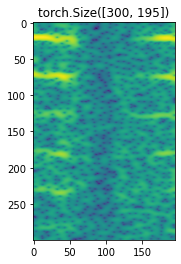

In [4]:
plt.imshow(train_dataset[0][0][0]);
plt.title(train_dataset[0][0][0].shape);

In [5]:
# from fractions import gcd
# def cf(num1,num2):
#     n=[]
#     g=gcd(num1, num2)
#     for i in range(1, g+1): 
#         if g%i==0: 
#             n.append(i)
#     return n
# cf(300,195)

In [6]:
outs=2

model = ViT(image_size=300,
       patch_size=15,
       num_classes=outs,
       dim=1024,
       depth=6,
       heads=16,
       mlp_dim=2048,
       dropout=0.1,
       emb_dropout=0.1,)


class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(label_smoothing=0.1, weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [7]:
if train_or_load_pretrained == 'train':
    # Choosing whether to train on a gpu
    train_on_gpu = torch.cuda.is_available()
    print(f'Train on gpu: {train_on_gpu}')# Number of gpus
    model = model.to('cuda', dtype=torch.float)

    results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
    best_valacc = 0
    # Model training
    for epoch in range(num_epochs):
        # Going through the training set
        correct_train = 0
        model.train()
        for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):          
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            for param in model.parameters():
                param.grad = None
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_train / len(train_dataset) * 100.
        torch.cuda.empty_cache()


        # Going through the validation set
        correct_valid = 0
        model.eval()
        with torch.no_grad():
            for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
                y_batch = torch.as_tensor(y_batch)
                x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
                pred = model(x_batch)

                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
                val_loss = criterion(pred, y_batch)
        valid_accuracy = correct_valid / len(valid_dataset) * 100.

        scheduler.step()


        # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")

        is_best = valid_accuracy > best_valacc
        if is_best:
            print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
        best_valacc = max(valid_accuracy, best_valacc)
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_valacc': best_valacc,
            'loss': results['loss'].append(loss.detach().cpu()),
            'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
            'train_accuracy': results['train_accuracy'].append(train_accuracy),
            'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
            'optimizer' : optimizer.state_dict(),
        }, is_best, f"model_vit")

elif train_or_load_pretrained == 'load':
    model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/{pretrained_modelname}.pth.tar', model, optimizer)
    model = model.to('cuda', dtype=torch.float)
else:
    print("Set train_or_load_pretrained to either \'train\' or \'load\'")

Training..	:   0%|          | 0/813 [00:00<?, ?it/s]

Train on gpu: True


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 0: train_acc: 50.0% loss: 0.7164613,  val_loss: 0.7390069 val_acc: 43.6%
Validation accuracy improved from 0.00 to 43.56. Saving model..


Validating..	: 100%|██████████| 122/122 [02:26<00:00,  1.20s/it]


Epoch 1: train_acc: 50.1% loss: 0.6934223,  val_loss: 0.6354956 val_acc: 43.6%


Validating..	: 100%|██████████| 122/122 [02:31<00:00,  1.24s/it]


Epoch 2: train_acc: 50.7% loss: 0.7194660,  val_loss: 0.6858396 val_acc: 43.7%
Validation accuracy improved from 43.56 to 43.71. Saving model..


Validating..	: 100%|██████████| 122/122 [02:29<00:00,  1.23s/it]


Epoch 3: train_acc: 50.0% loss: 0.6820825,  val_loss: 0.7189115 val_acc: 56.4%
Validation accuracy improved from 43.71 to 56.44. Saving model..


Validating..	: 100%|██████████| 122/122 [02:31<00:00,  1.24s/it]


Epoch 4: train_acc: 49.9% loss: 0.6811353,  val_loss: 0.6823649 val_acc: 56.4%


Validating..	: 100%|██████████| 122/122 [02:31<00:00,  1.24s/it]


Epoch 5: train_acc: 50.2% loss: 0.7002912,  val_loss: 0.6893858 val_acc: 43.6%


Validating..	: 100%|██████████| 122/122 [02:29<00:00,  1.23s/it]


Epoch 6: train_acc: 50.1% loss: 0.6924415,  val_loss: 0.7292219 val_acc: 56.4%


Validating..	: 100%|██████████| 122/122 [02:30<00:00,  1.23s/it]


Epoch 7: train_acc: 49.9% loss: 0.6872948,  val_loss: 0.6942360 val_acc: 58.3%
Validation accuracy improved from 56.44 to 58.27. Saving model..


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 8: train_acc: 50.6% loss: 0.6897205,  val_loss: 0.6774600 val_acc: 56.4%


Validating..	: 100%|██████████| 122/122 [02:29<00:00,  1.22s/it]


Epoch 9: train_acc: 50.4% loss: 0.6915114,  val_loss: 0.7049174 val_acc: 43.6%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 10: train_acc: 50.7% loss: 0.6978635,  val_loss: 0.7038701 val_acc: 44.1%


Validating..	: 100%|██████████| 122/122 [02:29<00:00,  1.22s/it]


Epoch 11: train_acc: 51.0% loss: 0.6693655,  val_loss: 0.6193607 val_acc: 48.3%


Validating..	: 100%|██████████| 122/122 [02:31<00:00,  1.24s/it]


Epoch 12: train_acc: 58.6% loss: 0.6432316,  val_loss: 0.6539648 val_acc: 64.2%
Validation accuracy improved from 58.27 to 64.19. Saving model..


Validating..	: 100%|██████████| 122/122 [02:30<00:00,  1.23s/it]


Epoch 13: train_acc: 61.2% loss: 0.6688575,  val_loss: 0.5866519 val_acc: 65.2%
Validation accuracy improved from 64.19 to 65.22. Saving model..


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 14: train_acc: 63.0% loss: 0.6734744,  val_loss: 0.6906819 val_acc: 68.5%
Validation accuracy improved from 65.22 to 68.54. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 15: train_acc: 64.2% loss: 0.6452743,  val_loss: 0.6704350 val_acc: 68.3%


Validating..	: 100%|██████████| 122/122 [02:29<00:00,  1.22s/it]


Epoch 16: train_acc: 65.0% loss: 0.5605795,  val_loss: 0.6373968 val_acc: 68.8%
Validation accuracy improved from 68.54 to 68.84. Saving model..


Validating..	: 100%|██████████| 122/122 [02:30<00:00,  1.23s/it]


Epoch 17: train_acc: 65.2% loss: 0.7174708,  val_loss: 0.6470674 val_acc: 67.0%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 18: train_acc: 66.9% loss: 0.5703059,  val_loss: 0.5252420 val_acc: 58.4%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 19: train_acc: 67.2% loss: 0.5436944,  val_loss: 0.7165543 val_acc: 57.3%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.21s/it]


Epoch 20: train_acc: 68.3% loss: 0.5801508,  val_loss: 0.5095721 val_acc: 69.4%
Validation accuracy improved from 68.84 to 69.36. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 21: train_acc: 68.8% loss: 0.5690116,  val_loss: 0.5900573 val_acc: 72.9%
Validation accuracy improved from 69.36 to 72.86. Saving model..


Validating..	: 100%|██████████| 122/122 [02:25<00:00,  1.19s/it]


Epoch 22: train_acc: 69.4% loss: 0.5214818,  val_loss: 0.4913049 val_acc: 72.9%
Validation accuracy improved from 72.86 to 72.88. Saving model..


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.21s/it]


Epoch 23: train_acc: 69.7% loss: 0.6425540,  val_loss: 0.5240286 val_acc: 70.2%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.21s/it]


Epoch 24: train_acc: 70.4% loss: 0.5979765,  val_loss: 0.6763629 val_acc: 73.1%
Validation accuracy improved from 72.88 to 73.09. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 25: train_acc: 70.8% loss: 0.6227837,  val_loss: 0.9264813 val_acc: 73.2%
Validation accuracy improved from 73.09 to 73.17. Saving model..


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.21s/it]


Epoch 26: train_acc: 70.7% loss: 0.5523685,  val_loss: 0.5285563 val_acc: 70.6%


Validating..	: 100%|██████████| 122/122 [02:25<00:00,  1.19s/it]


Epoch 27: train_acc: 71.4% loss: 0.5961500,  val_loss: 0.7111904 val_acc: 73.4%
Validation accuracy improved from 73.17 to 73.45. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 28: train_acc: 72.0% loss: 0.5890396,  val_loss: 0.4840007 val_acc: 74.1%
Validation accuracy improved from 73.45 to 74.09. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 29: train_acc: 71.7% loss: 0.5918293,  val_loss: 0.3791870 val_acc: 73.2%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 30: train_acc: 71.8% loss: 0.6269785,  val_loss: 0.6105952 val_acc: 74.0%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 31: train_acc: 72.2% loss: 0.4482777,  val_loss: 0.5024140 val_acc: 74.5%
Validation accuracy improved from 74.09 to 74.53. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 32: train_acc: 72.4% loss: 0.4702230,  val_loss: 0.5333730 val_acc: 73.1%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 33: train_acc: 72.8% loss: 0.5421430,  val_loss: 0.6865464 val_acc: 75.2%
Validation accuracy improved from 74.53 to 75.23. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 34: train_acc: 72.8% loss: 0.5098904,  val_loss: 0.6000010 val_acc: 64.0%


Validating..	: 100%|██████████| 122/122 [02:24<00:00,  1.19s/it]


Epoch 35: train_acc: 73.2% loss: 0.5117310,  val_loss: 0.5417721 val_acc: 75.4%
Validation accuracy improved from 75.23 to 75.38. Saving model..


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 36: train_acc: 73.2% loss: 0.4414092,  val_loss: 0.5784675 val_acc: 75.5%
Validation accuracy improved from 75.38 to 75.51. Saving model..


Validating..	: 100%|██████████| 122/122 [02:25<00:00,  1.19s/it]


Epoch 37: train_acc: 73.3% loss: 0.5653151,  val_loss: 0.5164376 val_acc: 73.2%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 38: train_acc: 73.7% loss: 0.6006510,  val_loss: 0.6367649 val_acc: 74.3%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 39: train_acc: 73.6% loss: 0.4722987,  val_loss: 0.6541103 val_acc: 63.7%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 40: train_acc: 73.9% loss: 0.5272226,  val_loss: 0.6329550 val_acc: 64.9%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 41: train_acc: 73.8% loss: 0.5916804,  val_loss: 0.5470509 val_acc: 76.1%
Validation accuracy improved from 75.51 to 76.13. Saving model..


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 42: train_acc: 74.3% loss: 0.5243439,  val_loss: 0.6774328 val_acc: 73.5%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 43: train_acc: 74.1% loss: 0.5254419,  val_loss: 0.6571748 val_acc: 69.2%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 44: train_acc: 74.4% loss: 0.6283677,  val_loss: 0.7248895 val_acc: 70.5%


Validating..	: 100%|██████████| 122/122 [02:29<00:00,  1.22s/it]


Epoch 45: train_acc: 74.7% loss: 0.5048878,  val_loss: 0.5930935 val_acc: 70.9%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 46: train_acc: 74.9% loss: 0.4631892,  val_loss: 0.6437995 val_acc: 66.8%


Validating..	: 100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 47: train_acc: 74.8% loss: 0.5883494,  val_loss: 0.5412984 val_acc: 70.5%


Validating..	: 100%|██████████| 122/122 [02:31<00:00,  1.24s/it]


Epoch 48: train_acc: 75.0% loss: 0.5911588,  val_loss: 0.5218826 val_acc: 74.3%


Validating..	: 100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 49: train_acc: 75.2% loss: 0.6646684,  val_loss: 0.5669512 val_acc: 69.1%


## Testing on test set

In [9]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_vit.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 803/803 [16:51<00:00,  1.26s/it]

Accuracy: 65.63
Balanced accuracy: 66.72
Confusion matrix: 
[[0.86078561 0.13921439]
 [0.52642441 0.47357559]]


## Testing on extra mebios data

In [10]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	:   4%|▎         | 25/712 [00:39<18:02,  1.58s/it] 


KeyboardInterrupt: 

### Confusion matrix

In [ ]:
from utils import get_all_preds
df_out = get_all_preds(model, test_dataloader, dataframe=True, final_nodes=2)
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
#plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatmain.eps", format='eps', bbox_inches='tight');